In [ ]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from arcgis.raster import ImageryLayer
from arcgis.geoenrichment import enrich
import pandas as pd

In [ ]:
print(arcgis.__version__)

In [ ]:
gis = GIS('https://imagery.bd.esri.com/portal', client_id='')


In [5]:
ra_supported = False
if arcgis.raster.analytics.is_supported(gis) == True:
    ra_supported = True
    print('Raster Analytics is Supported in your Portal')


Raster Analytics is Supported in your Portal


In [6]:
landsat_item = gis.content.search('landsat_OLI_la_2017', 'Imagery Layer', outside_org=False)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"landsat_OLI_la_2017" type:Imagery Layer owner:jame9217@esri.com>

In [7]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'type': 'extent', 
       'xmax': -13305000, 'xmin': -13315000, 'ymax': 4106000, 'ymin': 4052000}
landsat.extent = aoi


In [8]:
selected = landsat.filter_by(where="(Category = 1)",
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, CloudCover, SensorName", order_by_fields="AcquisitionDate").df
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(2)

,AcquisitionDate,CloudCover,OBJECTID,SensorName,Shape_Area,Shape_Length,SHAPE
0,2017-11-23 18:34:42.440,0.0441,3,Landsat 8,8.293642e+10,1.152012e+06,"{'rings': [[[-13490396.5134, 4251693.058799997..."
1,2017-12-09 18:34:39.504,0.2136,2,Landsat 8,8.293690e+10,1.152016e+06,"{'rings': [[[-13490028.6125, 4251708.814999998..."


In [9]:
prefire = landsat.filter_by('OBJECTID=3') # 2017-11-23 
midfire = landsat.filter_by('OBJECTID=2') # 2017-12-09

In [10]:
from arcgis.raster.functions import *


In [11]:
# apply(midfire, 'Natural Color with DRA')

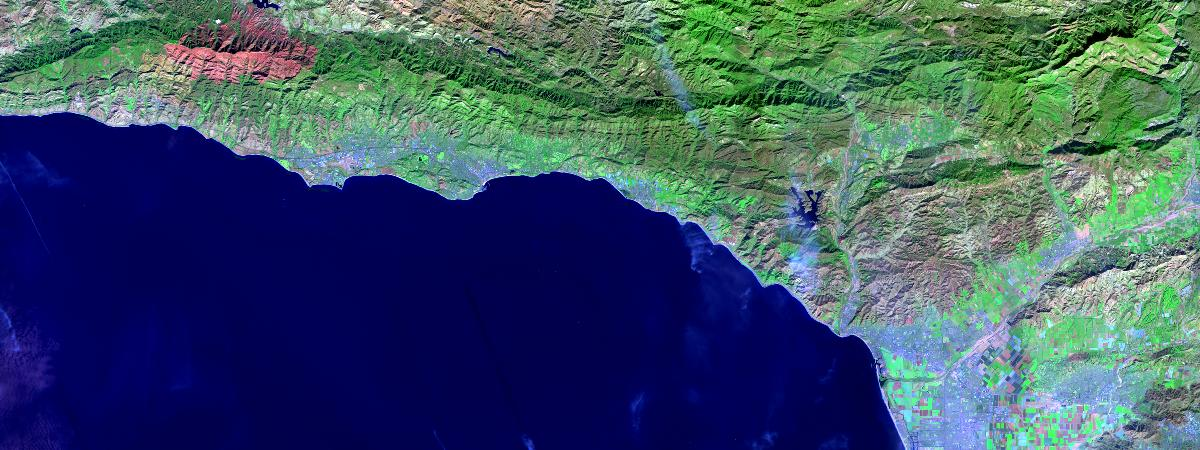

In [12]:
extract_band(prefire, [6, 4, 1])


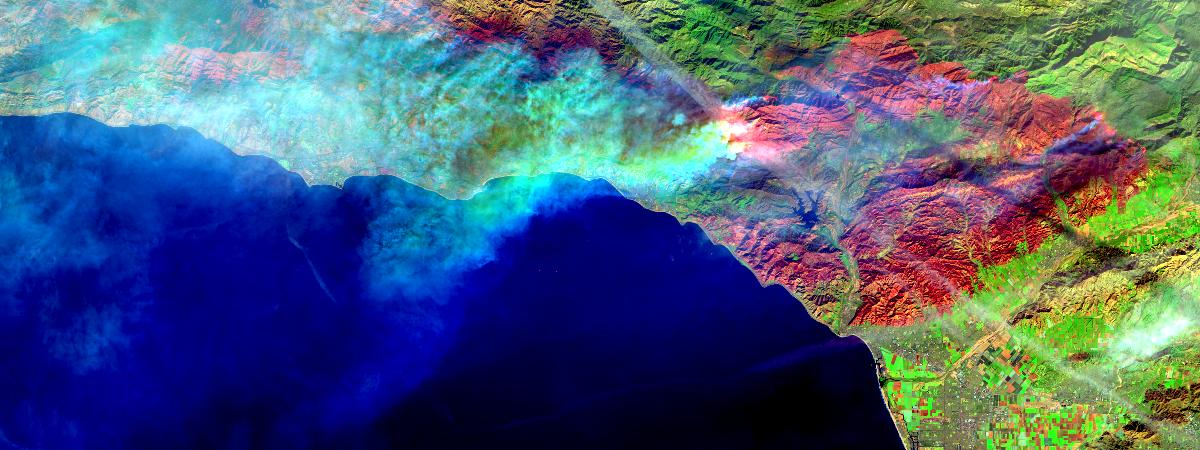

In [13]:
extract_band(midfire, [6, 4, 1])

In [14]:
nbr_prefire = band_arithmetic(prefire, "(b5 - b7) / (b5 + b7)")
nbr_postfire = band_arithmetic(midfire, "(b5 - b7) / (b5 + b7)")

nbr_diff = nbr_prefire - nbr_postfire

In [15]:
# extband_bf_wf = extract_band(prefire, [6, 4, 1])
# extband_img_srv_bf = extband_bf_wf.save('thomas burn prefire', for_viz=True)

In [16]:
# extband_mf_wf = extract_band(midfire, [6, 4, 1])
# extband_img_srv_mf = extband_mf_wf.save('thomas burn midfire', for_viz=True)

In [17]:
mask = remap(nbr_diff,
             input_ranges=[0.1, 0.27, 0.27, 0.44, 0.44, 0.66, 0.66, 1],  # change in NBR
             output_values=[1, 2, 3, 4],                                 # burn severity
             no_data_ranges=[-1, 0.1], astype='u8')

In [18]:
ext = {"xmax": -13246079.10806628, "ymin": 4035733.9433013694, "xmin": -13438700.419344831, "ymax": 4158033.188557592,
       "spatialReference": {"wkid": 102100, "latestWkid": 3857}, "type": "extent"}
pixx = (ext['xmax'] - ext['xmin']) / 1200.0
pixy = (ext['ymax'] - ext['ymin']) / 450.0

In [19]:
res = mask.compute_histograms(ext, pixel_size={'x':pixx, 'y':pixy})
numpix = 0
for i in res['histograms'][0]['counts']:
    numpix += i
    
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

print('Thomas fire had consumed {:,} acres by {}.'.format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

Thomas fire had consumed 169,108 acres by 2017-12-09.


In [20]:
burnt_areas = colormap(mask, colormap=[[4, 0xFF, 0xC3, 0],
                            [3, 0xFA, 0x8E, 0],
                            [2, 0xF2, 0x55, 0],
                            [1, 0xE6, 0,    0]])

In [21]:
m = gis.map('Carpinteria, CA', zoomlevel=10)
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [22]:
m.add_layer([extract_band(midfire, [6, 4, 1]), burnt_areas])


In [23]:
m1 = gis.map('Carpinteria, CA', zoomlevel=10)
m1

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [24]:
# exb_midfire = extract_band(midfire, [6, 4, 1])
# result_lyr = exb_midfire.save('exb_midfire', for_viz=False)

In [25]:
m1.add_layer(burnt_areas)


In [26]:
type(burnt_areas)

arcgis.raster._layer.ImageryLayer

In [35]:
wild_fire_area = burnt_areas.save('thomas_fire_burned_area', for_viz=True)

In [28]:
from arcgis.features import FeatureLayer

In [29]:
live_fires_polygon = FeatureLayer('https://services6.arcgis.com/l7uujk4hHifqabRB/arcgis/rest/services/Thomas_Fire/FeatureServer/1')

In [36]:
live_fires_df = live_fires_polygon.query().df                                           

In [37]:
m3 = gis.map('Santa Barbara, Ca', zoomlevel=10)
m3

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [40]:
m3.add_layer(live_fires_polygon)

In [41]:
from arcgis.geoenrichment import *

In [42]:
thomas_pop = enrich(live_fires_df, 'Age')
thomas_pop
gis.content.import_data(df=thomas_pop, title='Age, Population, and Gender Statistics for population inside Thomas Fire Burn Area')

<Item title:"Age, Population, and Gender Statistics for population inside Thomas Fire Burn Area" type:Feature Layer Collection owner:jame9217@esri.com>

In [43]:
type(thomas_pop)

arcgis.features._data.geodataset.geodataframe.SpatialDataFrame

In [44]:
# plot and examine the most at risk male and female age 
# demographics as a resutlt of the Thomas Fire

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as plot

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')

sf = thomas_pop.T
sf.reset_index(inplace=True)
sf['age'] = sf['index'].str.extract('(\d+)')

fem = sf[sf['index'].str.startswith('FEM')]
fem.rename(columns={0:'female'}, inplace=True)
fem['age'] = pd.to_numeric(fem['age'])
fem.sort_values(by='age', ascending=False, inplace=True)

male = sf[sf['index'].str.startswith('MALE')]
male.rename(columns={0:'male'}, inplace=True)
male['age'] = pd.to_numeric(male['age'])
male.sort_values(by='age', ascending=False, inplace=True)

popdf = pd.merge(male, fem, on='age')
popdf['agelabel'] = popdf['age'].map(str) + ' - ' + (popdf['age']+4).map(str)
popdf['male'] = -popdf['male']

In [48]:
print('Number of people in fire perimeter: ' + str(popdf['female'].sum() - popdf['male'].sum()))


Number of people in fire perimeter: 11228


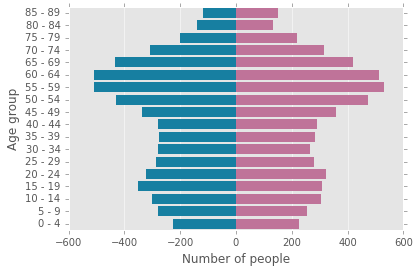

In [49]:
sns.barplot(x="female", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
sns.barplot(x="male",   y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
plt.ylabel('Age group')
plt.xlabel('Number of people');

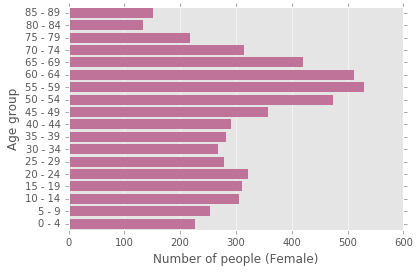

In [50]:
sns.barplot(x="female", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
plt.ylabel('Age group')
plt.xlabel('Number of people (Female)')
plt.savefig('Females by age in burn area');


In [51]:
male = sf[sf['index'].str.startswith('MALE')]
male.rename(columns={0:'male'}, inplace=True)
male['age'] = pd.to_numeric(male['age'])
male.sort_values(by='age', ascending=False, inplace=True)

popdf = pd.merge(male, fem, on='age')
popdf['agelabel'] = popdf['age'].map(str) + ' - ' + (popdf['age']+4).map(str)
popdf['male'] = popdf['male']

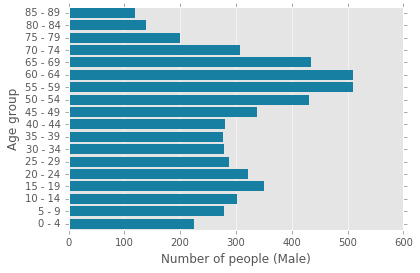

In [52]:
sns.barplot(x="male",   y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
plt.ylabel('Age group')
plt.xlabel('Number of people (Male)')
plt.savefig('males by age in burn area');